In [1]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

'Connected: None@chinook.db'

In [2]:
%%sql
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view");

Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

## Intro

Our imaginary record store *Chinook* has signed a contract with a new record label. Four albums from four different artists are presented as potential candidates to be added to the store, each representing a different genre of music. The artists are:

In [4]:
pd.DataFrame.from_dict({
    "Artist": ["Regal", "Red Tone", "Meteor and the Girls", "Slim Jim Bites"],
    "Genre": ["Hip-Hop", "Punk", "Pop", "Blues"]})

,Artist,Genre
0,Regal,Hip-Hop
1,Red Tone,Punk
2,Meteor and the Girls,Pop
3,Slim Jim Bites,Blues


### Highest sales:

Out of the 4, we must select 3, and to do that we must first identify which genres sell the most in the US:

In [5]:
us_sales_df = pd.read_sql_query(
    '''WITH 
        itrack AS (
            SELECT 
                t.track_id,
                g.name genre
            FROM track t INNER JOIN genre g
            ON t.genre_id = g.genre_id),
        iinv AS (
            SELECT 
                it.genre,
                SUM(il.quantity) quantity
            FROM invoice i
            LEFT JOIN invoice_line il
              ON i.invoice_id = il.invoice_id
            LEFT JOIN itrack it
              ON il.track_id = it.track_id
            WHERE i.billing_country = 'USA'
            GROUP BY it.genre)
    
    SELECT 
        genre,
        quantity,
        ROUND(
            CAST(quantity AS Float)/(
            SELECT 
                SUM(quantity)
            FROM iinv), 4) pct_market
    FROM iinv
    ORDER BY 3 DESC;''', 'sqlite:///chinook.db')

In [6]:
us_sales_df.head()

,genre,quantity,pct_market
0,Rock,561,0.5338
1,Alternative & Punk,130,0.1237
2,Metal,124,0.1180
3,R&B/Soul,53,0.0504
4,Blues,36,0.0343


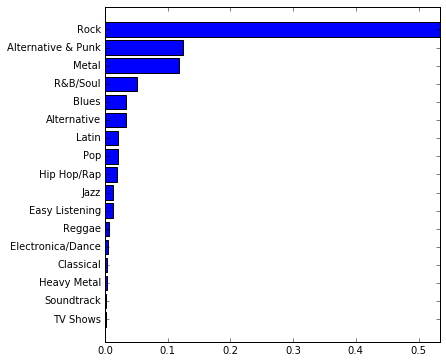

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))

genre_pos = np.arange(us_sales_df.loc[:, 'genre'].shape[0])

ax.barh(genre_pos, us_sales_df.loc[:, 'pct_market'], align='center')
ax.set_yticks(genre_pos)
ax.set_yticklabels(us_sales_df.loc[:, 'genre'])
ax.invert_yaxis()

ax.margins(0, 0.05)

plt.axis('tight')
plt.show()

As we can see, surprisingly *Rock* takes first as the most sold genre, responsible for over half the sales. According to the sales in the US, the top 3 artists presented to us, would be ranked as follows: *Red Tone, Meteor and the Girls, Slim Jim Bites*.

### Sales agent performance:

We're next tasked with analyzing the performance of *Chinook's* sales support agents, but let's first look for any markers that might correlate to performance among *customer, invoice, employee* tables:

In [8]:
%%sql
PRAGMA database_list;

Done.


seq,name,file
0,main,/home/dq/notebook/chinook.db


In [9]:
%%sql
DROP VIEW IF EXISTS c_inv;

CREATE TEMP VIEW c_inv AS
    SELECT 
        c.support_rep_id rep_id,
        c.first_name||' '||c.last_name name,
        COALESCE(c.company, NULL) company,
        c.country,
        ROUND(SUM(i.total), 2) purchase_total,
        ROUND(AVG(i.total), 2) purchase_avg,
        COUNT(i.total) purchase_qt
    FROM main.customer c LEFT JOIN main.invoice i 
    ON c.customer_id = i.customer_id
    GROUP BY 2
    ORDER BY 1;

Done.
Done.


[]

#### Customer Summary

In [10]:
%%sql
SELECT *
FROM c_inv;

Done.


rep_id,name,company,country,purchase_total,purchase_avg,purchase_qt
3,Edward Francis,None,Canada,91.08,7.01,13
3,Ellie Sullivan,None,Canada,75.24,6.27,12
3,Emma Jones,None,United Kingdom,68.31,8.54,8
3,Frank Ralston,None,USA,71.28,8.91,8
3,François Tremblay,None,Canada,99.99,11.11,9
3,Fynn Zimmermann,None,Germany,94.05,9.41,10
3,Hugh O'Reilly,None,Ireland,114.84,8.83,13
3,Isabelle Mercier,None,France,73.26,6.1,12
3,Jennifer Peterson,Rogers Canada,Canada,66.33,7.37,9
3,Ladislav Kovács,None,Hungary,78.21,7.82,10


#### Employee Summary

In [11]:
%%sql
DROP VIEW IF EXISTS emp;

CREATE TEMP VIEW emp AS
    SELECT 
        e.employee_id rep_id,
        e.title,
        e.first_name||' '||e.last_name rep_name,
        COALESCE(s.first_name||' '||s.last_name, "NONE") sup_name,
        e.birthdate,
        e.hire_date,
        e.country||', '||e.city location
    FROM employee e INNER JOIN employee s
    ON e.reports_to = s.employee_id
    ORDER BY 1;

Done.
Done.


[]

In [12]:
%%sql
SELECT *
FROM emp;

Done.


rep_id,title,rep_name,sup_name,birthdate,hire_date,location
2,Sales Manager,Nancy Edwards,Andrew Adams,1958-12-08 00:00:00,2016-05-01 00:00:00,"Canada, Calgary"
3,Sales Support Agent,Jane Peacock,Nancy Edwards,1973-08-29 00:00:00,2017-04-01 00:00:00,"Canada, Calgary"
4,Sales Support Agent,Margaret Park,Nancy Edwards,1947-09-19 00:00:00,2017-05-03 00:00:00,"Canada, Calgary"
5,Sales Support Agent,Steve Johnson,Nancy Edwards,1965-03-03 00:00:00,2017-10-17 00:00:00,"Canada, Calgary"
6,IT Manager,Michael Mitchell,Andrew Adams,1973-07-01 00:00:00,2016-10-17 00:00:00,"Canada, Calgary"
7,IT Staff,Robert King,Michael Mitchell,1970-05-29 00:00:00,2017-01-02 00:00:00,"Canada, Lethbridge"
8,IT Staff,Laura Callahan,Michael Mitchell,1968-01-09 00:00:00,2017-03-04 00:00:00,"Canada, Lethbridge"


#### Sales Rep Performance

In [13]:
%%sql
SELECT 
    e.rep_id,
    e.rep_name,
    e.birthdate,
    e.hire_date,
    ROUND(SUM(c.purchase_total), 2) total_val,
    ROUND(AVG(c.purchase_total), 2) avg_val,
    SUM(c.purchase_qt) total_qt,
    ROUND(AVG(c.purchase_qt)) avg_qt,
    COUNT(c.name) customer_qt,
    COUNT(c.company) company_qt,
    GROUP_CONCAT(c.company, ', ') companies 
FROM emp e INNER JOIN c_inv c
ON e.rep_id = c.rep_id
GROUP BY 1;

Done.


rep_id,rep_name,birthdate,hire_date,total_val,avg_val,total_qt,avg_qt,customer_qt,company_qt,companies
3,Jane Peacock,1973-08-29 00:00:00,2017-04-01 00:00:00,1731.51,82.45,212,10.0,21,4,"Rogers Canada, Embraer - Empresa Brasileira de Aeronáutica S.A., Riotur, Apple Inc."
4,Margaret Park,1947-09-19 00:00:00,2017-05-03 00:00:00,1584.0,79.2,214,11.0,20,3,"Woodstock Discos, Google Inc., JetBrains s.r.o."
5,Steve Johnson,1965-03-03 00:00:00,2017-10-17 00:00:00,1393.92,77.44,188,10.0,18,3,"Banco do Brasil S.A., Microsoft Corporation, Telus"


We can see that the worst performer *Steve Johnson* is neither the oldest nor youngest, but was the latest hire. He currently has the least amount of individual and company customers and sells the least amount of tracks, quantity-wise. 

#### Sales by Country

Next we are tasked with analyzing sales by country.

In [14]:
%%sql

DROP VIEW IF EXISTS country_sales;

CREATE TEMP VIEW country_sales AS
    SELECT 
        country,
        COUNT(name) customers,
        ROUND(SUM(purchase_total), 2) total_sales,
        SUM(purchase_qt) total_qt
    FROM c_inv
    GROUP BY 1
    ORDER BY 3;

SELECT *
FROM country_sales;

Done.
Done.
Done.


country,customers,total_sales,total_qt
Denmark,1,37.62,10
Argentina,1,39.6,5
Italy,1,50.49,9
Belgium,1,60.39,7
Netherlands,1,65.34,10
Austria,1,69.3,9
Norway,1,72.27,9
Sweden,1,75.24,10
Poland,1,76.23,10
Hungary,1,78.21,10


In [15]:
%%sql

WITH
    country_sales_other AS (
        SELECT
            CASE 
                WHEN customers > 1 THEN country
                ELSE 'Other'
                END AS country,
            SUM(customers) customers,
            SUM(total_sales) total_sales,
            SUM(total_qt) total_qt 
        FROM country_sales
        GROUP BY 1),
    country_sales_stats AS (
        SELECT
            country,
            customers,
            total_sales,
            ROUND(total_sales/customers, 2) avg_sales_customer,
            ROUND(total_sales/total_qt, 2) avg_sales_order
        FROM country_sales_other)

SELECT *
FROM (
    SELECT 
        c.*,
        CASE 
            WHEN c.country = 'Other' THEN 1
            ELSE 0
        END AS sort
    FROM country_sales_stats c) c
ORDER BY c.sort, c.customers DESC;

Done.


country,customers,total_sales,avg_sales_customer,avg_sales_order,sort
USA,13,1040.49,80.04,7.94,0
Canada,8,535.59,66.95,7.05,0
Brazil,5,427.68,85.54,7.01,0
France,5,389.07,77.81,7.78,0
Germany,4,334.62,83.66,8.16,0
United Kingdom,3,245.52,81.84,8.77,0
Czech Republic,2,273.24,136.62,9.11,0
India,2,183.15,91.58,8.72,0
Portugal,2,185.13,92.56,6.38,0
Other,15,1094.94,73.0,7.45,1


#### Notes:
USA is by far the biggest consumer, with the sum from all minority countries roughly equaling the sales of US alone. 

### Rough Times

The company is currently considering cutting costs by dropping albums as a whole and instead opting to buy select most popular tracks from albums. Our task is to decide whether that is a sound business decision by analyzing sales of albums as compared to tracks. 

There are edge cases which can be safely dropped as they were found to be inconsequential:
<ul>
    <li> albums with very few tracks
    <li> purchases of individual tracks that sum to whole albums
</ul>

In [16]:
%%sql

DROP VIEW IF EXISTS inv_albums;
DROP VIEW IF EXISTS alb_tracks;

CREATE TEMP VIEW inv_albums AS 
    SELECT 
        il.invoice_id inv_id,
        COUNT(il.track_id) tracks,
        CASE 
            WHEN COUNT(DISTINCT t.album_id) > 1 THEN 'Mixed'
            ELSE GROUP_CONCAT(DISTINCT t.album_id)
        END AS album_id
    FROM invoice_line il
    LEFT JOIN track t ON il.track_id = t.track_id
    GROUP BY 1;
    
CREATE TEMP VIEW alb_tracks AS 
    SELECT 
        a.album_id,
        COUNT(t.track_id) tracks
    FROM album a
    LEFT JOIN track t ON a.album_id = t.album_id
    GROUP BY 1;

Done.
Done.
Done.
Done.


[]

In [37]:
%%sql

DROP VIEW IF EXISTS purchase_types;

CREATE TEMP VIEW purchase_types AS
    SELECT
        i.inv_id,
        CASE 
            WHEN (i.album_id = 'Mixed') OR (i.tracks != a.tracks) THEN 'Select Tracks'
            ELSE 'Full Album'
        END AS purchase_type
    FROM inv_albums i
    LEFT JOIN alb_tracks a ON i.album_id = a.album_id;
    
SELECT * FROM purchase_types;

Done.
Done.
Done.


inv_id,purchase_type
1,Full Album
2,Select Tracks
3,Select Tracks
4,Select Tracks
5,Full Album
6,Select Tracks
7,Select Tracks
8,Select Tracks
9,Select Tracks
10,Select Tracks


In [38]:
%%sql

SELECT 
    (SELECT
         COUNT(purchase_type)
     FROM purchase_types
     WHERE purchase_type = 'Full Album') album_sales,
    COUNT(purchase_type) total_sales
FROM purchase_types;

Done.


album_sales,total_sales
114,614


#### Notes:
As we can see, album purchases account for about 18% of the total sales. This in itself is a significant number but needs to be analyzed further by examining the invoice total made from such purchases as compared to the rest. 